USE CASE predicting the number of air passengers


## Introduction

The synthetic dataset is a case study with company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAS</code> which is related to the number of passengers
</ul>

The goal is to predict the <code>log_PAS</code> column. 
The prediction quality is measured by RMSE. 


In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [25]:
!pip install -U seaborn  # if you don't have it, or pip3 for python3

Requirement already up-to-date: seaborn in /Users/hapham/opt/anaconda3/lib/python3.7/site-packages (0.10.1)


In [26]:
# optional
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

In [27]:
data = pd.read_csv("train.csv")

In [28]:
data.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAS,std_wtd
0,2012-10-21,DFW,SFO,14.600000,10.757779,11.575837
1,2012-09-13,LAX,ATL,14.730769,11.808097,13.364304
2,2012-09-04,ORD,IAH,8.470588,10.865349,5.885551
3,2012-08-13,DEN,PHX,8.200000,10.710562,6.292853
4,2012-09-10,ORD,SEA,12.090909,11.498355,9.138662


In [29]:
data['Departure'].unique()

array(['DFW', 'LAX', 'ORD', 'DEN', 'MCO', 'IAH', 'MIA', 'ATL', 'LGA',
       'SEA', 'PHX', 'CLT', 'DTW', 'LAS', 'EWR', 'MSP', 'BOS', 'PHL',
       'SFO', 'JFK'], dtype=object)

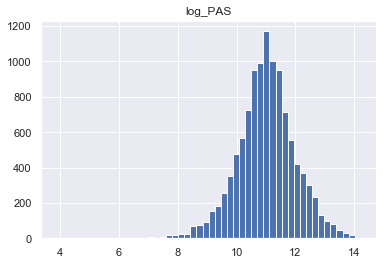

In [30]:
data.hist(column='log_PAS', bins=50);

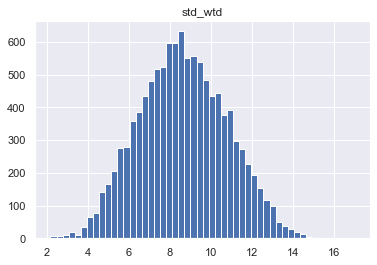

In [31]:
data.hist('std_wtd', bins=50);

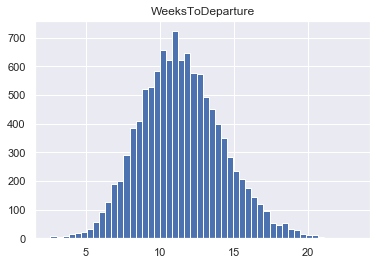

In [32]:
data.hist('WeeksToDeparture', bins=50);

In [33]:
data.describe()

,WeeksToDeparture,log_PAS,std_wtd
count,11128.000000,11128.000000,11128.000000
mean,11.466842,10.997728,8.635226
std,2.807131,0.998242,2.145805
min,2.625000,3.878108,2.160247
25%,9.523810,10.427055,7.109619
50%,11.304348,11.008268,8.582272
75%,13.259259,11.590093,10.162525
max,23.163265,14.224277,17.035677


In [34]:
data.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
log_PAS             float64
std_wtd             float64
dtype: object

In [35]:
data.shape

(11128, 6)

In [42]:
print (data["log_PAS"].mean())
print (data['log_PAS'].std())

10.99772803448557
0.9982419545897369


## Preprocessing for prediction

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

In [43]:
data_encoded = data

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Departure'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Arrival'], prefix='a'))
data_encoded = data_encoded.drop('Departure', axis=1)
data_encoded = data_encoded.drop('Arrival', axis=1)

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
data_encoded['DateOfDeparture'] = pd.to_datetime(data_encoded['DateOfDeparture'])
data_encoded['year'] = data_encoded['DateOfDeparture'].dt.year
data_encoded['month'] = data_encoded['DateOfDeparture'].dt.month
data_encoded['day'] = data_encoded['DateOfDeparture'].dt.day
data_encoded['weekday'] = data_encoded['DateOfDeparture'].dt.weekday
data_encoded['week'] = data_encoded['DateOfDeparture'].dt.week
data_encoded['n_days'] = data_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

data_encoded = data_encoded.join(pd.get_dummies(data_encoded['year'], prefix='y'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['month'], prefix='m'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['day'], prefix='d'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['weekday'], prefix='wd'))
data_encoded = data_encoded.join(pd.get_dummies(data_encoded['week'], prefix='w'))

In [44]:
data_encoded.tail(5)

,DateOfDeparture,WeeksToDeparture,log_PAS,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
11123,2011-11-22,11.636364,10.334322,8.888438,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2011,11,22,1,47,15300,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11124,2011-12-14,13.541667,12.459632,10.341891,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,12,14,2,50,15322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
11125,2013-01-28,5.583333,11.381124,3.752777,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2013,1,28,0,5,15733,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11126,2011-09-03,12.730769,11.308812,7.997788,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2011,9,3,5,35,15220,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11127,2012-09-24,14.250000,11.619697,9.508768,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2012,9,24,0,39,15607,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### A linear regressor baseline

We drop the target column and the original data column.

In [45]:
features = data_encoded.drop(['log_PAS','DateOfDeparture'], axis=1)
X_columns = data_encoded.columns.drop(['log_PAS','DateOfDeparture'])
X = features.values
y = data_encoded['log_PAS'].values

In [46]:
# from sklearn.cross_validation import train_test_split #old python v2.3
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

It gives us a pretty nice improvement above baseline

In [85]:
from sklearn.linear_model import LinearRegression
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import  KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer

reg = LinearRegression()

#scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error')
k_fold = KFold(n_splits=5)
scores = cross_val_score(reg, X_train, y_train, cv=k_fold,n_jobs=3)

#print("log RMSE: {:.4f} +/-{:.4f}".format(
#    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

## Random Forests

In [81]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  KFold, cross_val_score
#from sklearn.metrics import mean_squared_error

n_estimators = 10
max_depth = 10
max_features = 10
reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

#scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error',n_jobs=1)
k_fold = KFold(n_splits=5)
scores = cross_val_score(reg, X_train, y_train, cv=k_fold,n_jobs=3)

print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: nan +/-nan
CPU times: user 20.8 ms, sys: 11 ms, total: 31.8 ms
Wall time: 349 ms


/Users/hapham/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


## Variable importances

In [89]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [90]:
len(X_columns)

153